In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/AV_AGE_ESTIMATION/Regression script'
%ls

/content/gdrive/.shortcut-targets-by-id/11RMVMm6VX89wDobNwd6SUfh-4Sin2gL9/AV_AGE_ESTIMATION/Regression script
checkpoint_regression.h5
checkpoint_vggface_regr_augmentation.h5
DataAugmentation_Preprocessing.py
Regression_augmentation.ipynb
shuffle_balanced_train.csv
shuffle_balanced_train_regression_673183.record
test_with_label.record
TFRecordBilanciato.py
Tools.py
VGGFACE_regression_batch64.h5


In [ ]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import random
from functools import partial

DATASET_SIZE = 673182
DATA_SUBSET_SIZE = int(1 * DATASET_SIZE)
train_size = int(0.85 * DATA_SUBSET_SIZE)
val_size = int(0.15 * DATA_SUBSET_SIZE)
test_size = int(0 * DATA_SUBSET_SIZE)
IMAGE_SIZE = [124, 124]
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

In [ ]:
def decode_image(image):
    image = tf.io.decode_raw(image, tf.uint8)
    print(image)
    image = tf.cast(image, tf.float32) / 255
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    # image = tf.image.resize_with_pad(image,224,224)
    image = tf.reverse(image, axis=[-1])
    return image

In [ ]:
def read_tfrecord(example, labeled=True):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string), }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])

    image = data_augmentation(image)
    
    if labeled:
        label = tf.cast(example["label"], tf.float32)
        return image, label
    return image

In [ ]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files

    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order

    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [ ]:
def data_augmentation(image):

    #image=tf.image.random_contrast(image,0,0.1)

    image=tf.image.random_brightness(image,0.2)
    
    image=tf.image.random_flip_up_down(image)

    #image=tf.image.random_saturation(image,0,1.5)

    image=tf.image.random_jpeg_quality(image,10,20)

    return image

In [ ]:
def adjust(dataset):
    # dataset = dataset.cache() # This dataset fits in RAM
    dataset = dataset.repeat()
    dataset = dataset.shuffle(10000)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    # dataset = dataset.shuffle(2048)
    # dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    # dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
FILENAMES = "shuffle_balanced_train_regression_673183.record"

dataset = get_dataset(FILENAMES)

valid_set = dataset.take(val_size)
temp = dataset.skip(val_size)
train_set = temp.take(-1)

train_set = adjust(train_set)
valid_set = adjust(valid_set)

Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)


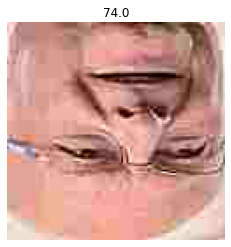

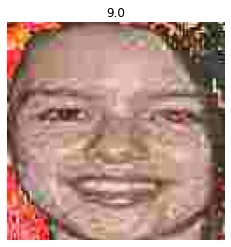

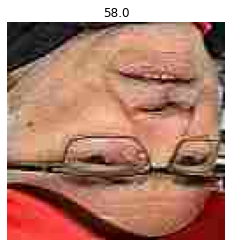

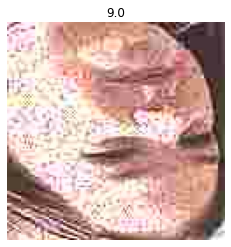

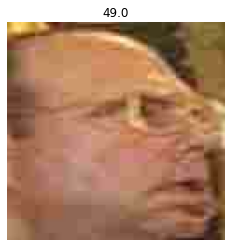

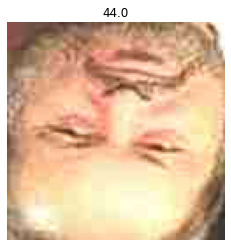

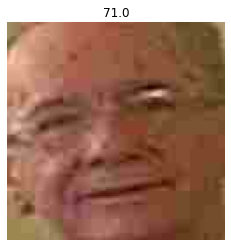

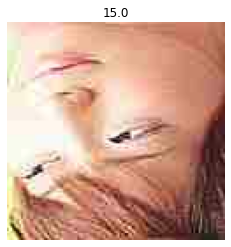

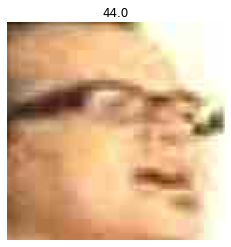

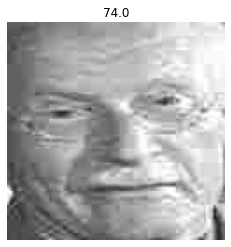

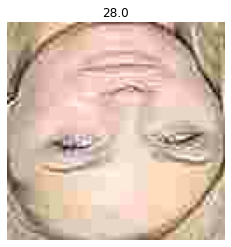

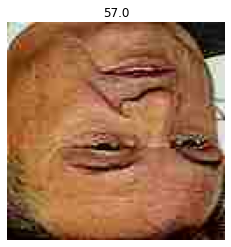

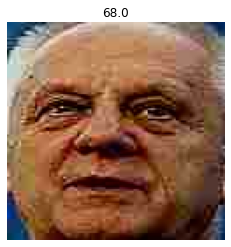

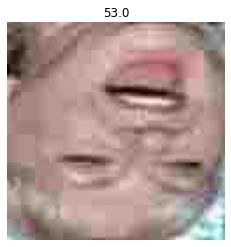

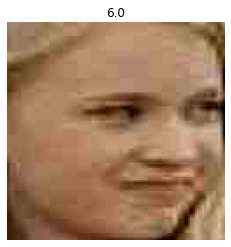

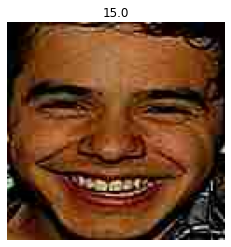

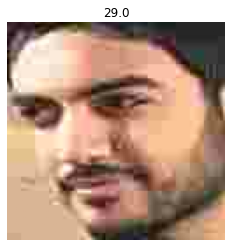

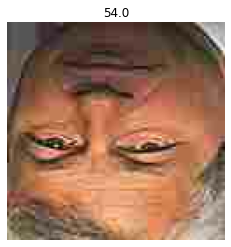

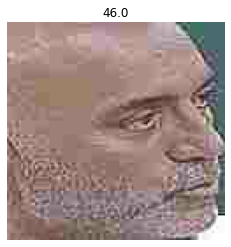

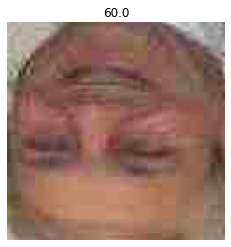

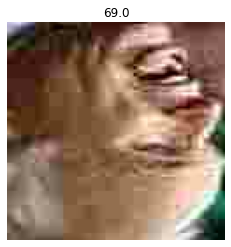

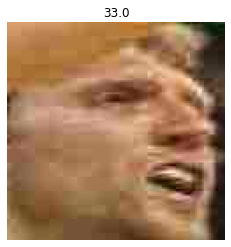

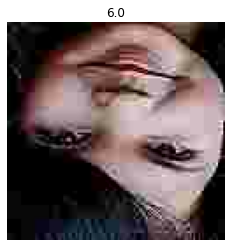

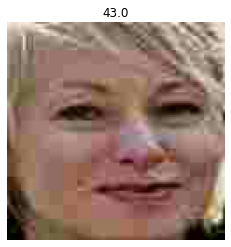

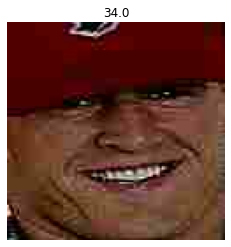

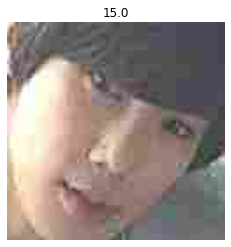

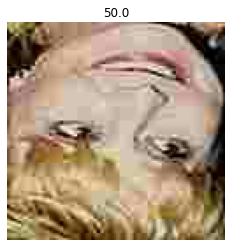

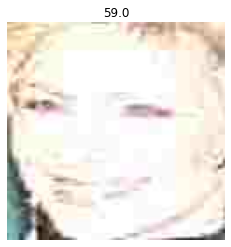

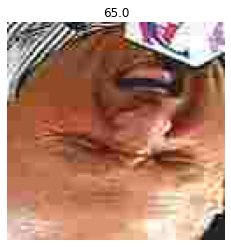

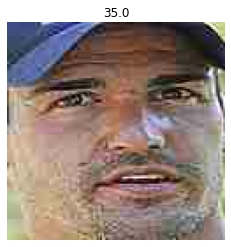

In [ ]:
# FOR PER STAMPA IMMAGINI BATCH (OPZIONALE)

image_batch, label_batch = next(iter(valid_set))

def show_batch(image_batch, label_batch):
    for n in range(30):
        plt.imshow(image_batch[n])
        plt.title((label_batch[n]))
        plt.axis('off')
        plt.show()

show_batch(image_batch.numpy(), label_batch.numpy())

In [4]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

!pip install keras_vggface

!pip install keras_applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-_e3vp9oe
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-_e3vp9oe
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=e5515c8b7c22ebc302254a36ef00012ee42608dd568645e892fe5e5e0ff87e29
  Stored in directory: /tmp/pip-ephem-wheel-cache-lsxvyry5/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 5.3MB/s 


In [ ]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input
from tensorflow.keras.applications import vgg16
from keras_vggface.vggface import VGGFace

# custom parameters
nb_class = 101
hidden_dim = 1024

vgg_model = VGGFace(include_top=False, weights='vggface', input_shape=(124, 124, 3), pooling='avg')
for layer in vgg_model.layers[:]:
    layer.trainable = False

last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim / 2, activation='relu', name='fc7')(x)
out = Dense(1, activation='relu', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)

custom_vgg_model.summary()

58916864/58909280 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 124, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 124, 124, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 124, 124, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 62, 62, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 62, 62, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 62, 62, 128)       147584    
______________________________________________________________

In [ ]:
# Definition of callbacks and learning rate

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from keras.optimizers import Adamax, SGD, RMSprop

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5,
                           min_delta=0.001, verbose=True),
             ModelCheckpoint(filepath='checkpoint_vggface_regr_augmentation.h5',
                             monitor='val_loss', mode='min', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2,
                               min_delta=0.02, factor=0.5, verbose=True)]

In [ ]:
epochs = 20
train_step = int(train_size / BATCH_SIZE)
valid_step = int(val_size / BATCH_SIZE)

# Compile your model
custom_vgg_model.compile(optimizer=RMSprop(learning_rate=initial_learning_rate),
                         loss='mse',
                         metrics=tf.keras.metrics.mae)

In [ ]:
history = custom_vgg_model.fit(
    train_set,
    epochs=epochs,
    steps_per_epoch=train_step,
    validation_steps=valid_step,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    validation_data=valid_set,
    verbose=True,
    callbacks=callbacks
)

custom_vgg_model.save_weights("VGGFACE_balanced_regression_augment.h5")

Epoch 1/20
8940/8940 [==============================] - 1195s 121ms/step - loss: 149.9736 - mean_absolute_error: 8.9772 - val_loss: 102.9503 - val_mean_absolute_error: 7.4615
Epoch 2/20
8940/8940 [==============================] - ETA: 0s - loss: 76.1009 - mean_absolute_error: 6.1535

In [5]:
import tensorflow as tf
from functools import partial
import csv
from keras.engine import Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from keras.optimizers import Adamax, SGD, RMSprop, Adam

DATASET_SIZE = 36
DATA_SUBSET_SIZE = int(1 * DATASET_SIZE)
train_size = int(0.0 * DATA_SUBSET_SIZE)
val_size = int(0.0 * DATA_SUBSET_SIZE)
test_size = int(1 * DATA_SUBSET_SIZE)
IMAGE_SIZE = [124, 124]
AUTOTUNE = tf.data.experimental.AUTOTUNE
FILENAMES = "test_with_label.record"


def decode_image(image):
    """
    This function decode the input image represented as tf.string
    :param image: tf.string data that represents an image
    :return: image as numpy.ndarray
    """
    image = tf.io.decode_raw(image, tf.uint8)
    image = tf.cast(image, tf.float32) / 255
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.reverse(image, axis=[-1])
    return image


def read_tfrecord(example, labeled=True):
    """
    This function read data in the tfrecord dataset
    :param example:
    :param labeled: choose if the tfrecord is labeled or not
    :return: images and labels
    """
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.string),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string), }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["label"], tf.string)
        return image, label


def load_dataset(filenames, labeled=True):
    """
    This function load the data from the tfrecord
    :param filenames: path of tfrecord
    :param labeled: choose if the tfrecord is labeled or not
    :return: returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    """
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    return dataset


def adjust(dataset, BATCH_SIZE):
    """
    :param dataset: input dataset
    :param BATCH_SIZE: number of samples for every batch
    :return: batched dataset
    """
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


def get_dataset(filenames, labeled=True):
    """
    :param filenames:  path of tfrecord
    :param labeled: choose if the tfrecord is labeled or not
    :return: dataset
    """
    dataset = load_dataset(filenames, labeled=labeled)
    print(dataset)
    return dataset


dataset = get_dataset(FILENAMES)

test_set = dataset.take(-1)

test_set = adjust(test_set, 36)



# custom parameters
nb_class = 1
#hidden_dim = 512

vgg_model = VGGFace(include_top=False, weights='vggface', input_shape=(124, 124, 3), pooling='avg')
for layer in vgg_model.layers[:]:
    layer.trainable = False

last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(512, activation='relu', name='fc6')(x)
x = Dense(512 , activation='relu', name='fc7')(x)
out = Dense(1, activation='relu', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)

custom_vgg_model.summary()

epochs = 20
train_step = int(train_size / 64)
valid_step = int(val_size / 64)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)
'''
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5,
                           min_delta=0.01, verbose=True),
             ModelCheckpoint(filepath='checkpoint_vggface_regression_RMSPROP_mae.h5',
                             monitor='val_loss', mode='min', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2,
                               min_delta=0.02, factor=0.5, verbose=True)]
                               '''

# Compile your model
custom_vgg_model.compile(optimizer=RMSprop(learning_rate=initial_learning_rate),
                         loss='mse',
                         metrics='mae')

custom_vgg_model.load_weights("VGGFACE_regression_batch64.h5")


def show_batch(image_batch, label_batch, DIM, MODE):
    """
    This function can show test images and the corresponding predicted labels
    and can write in a csv file the path of the image and the corresponding label
    :param image_batch: batch of images
    :param label_batch: batch of labels
    :param DIM: number of pair
    :param MODE: the operation that you want to make on the csv
    """
    with open('CARMINE.csv', mode=MODE, newline="") as train_file:
        train_writer = csv.writer(train_file, delimiter=',')
        for n in range(DIM):
            # plt.imshow(image_batch[n])
            img_array = tf.expand_dims(image_batch[n], axis=0)
            lista = custom_vgg_model.predict(img_array)[0]
            # plt.title('Label predetta: ' + str(lista) + 'Label originale: ' + str(label_batch[n]))
            # plt.show()
            print('Label predetta:' + str(lista) + 'Label originale: ' + str(label_batch[n]))
            train_writer.writerow([str(label_batch[n].decode('utf-8')), str(round(float(lista)))])
            # im_rgb = cv2.cvtColor(image_batch[n], cv2.COLOR_BGR2RGB)
            # cv2.resize(im_rgb,(250 ,250))
            # cv2.imshow('foto',im_rgb)
            # cv2.waitKey(0)


image_batch, label_batch = next(iter(test_set))
show_batch(image_batch.numpy(), label_batch.numpy(), 36, 'w')



<ParallelMapDataset shapes: ((124, 124, 3), ()), types: (tf.float32, tf.string)>
58916864/58909280 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 124, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 124, 124, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 124, 124, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 62, 62, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 62, 62, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 62, 62, 128